[Table of Contents](./table_of_contents.ipynb)

# Kalman Filter Math

In [1]:
%matplotlib inline

In [2]:
#format the book
import book_format
book_format.set_style()

If you've gotten this far I hope that you are thinking that the Kalman filter's fearsome reputation is somewhat undeserved. Sure, I hand waved some equations away, but I hope implementation has been fairly straightforward for you. The underlying concept is quite straightforward - take two measurements, or a measurement and a prediction, and choose the output to be somewhere between the two. If you believe the measurement more your guess will be closer to the measurement, and if you believe the prediction is more accurate your guess will lie closer to it. That's not rocket science (little joke - it is exactly this math that got Apollo to the moon and back!). 

To be honest I have been choosing my problems carefully. For an arbitrary problem designing the Kalman filter matrices can be extremely difficult. I haven't been *too tricky*, though. Equations like Newton's equations of motion can be trivially computed for Kalman filter applications, and they make up the bulk of the kind of problems that we want to solve. 

I have illustrated the concepts with code and reasoning, not math. But there are topics that do require more mathematics than I have used so far. This chapter presents the math that you will need for the rest of the book.

## Modeling a Dynamic System

A *dynamic system* is a physical system whose state (position, temperature, etc) evolves over time. Calculus is the math of changing values, so we use differential equations to model dynamic systems. Some systems cannot be modeled with differential equations, but we will not encounter those in this book.

Modeling dynamic systems is properly the topic of several college courses. To an extent there is no substitute for a few semesters of ordinary and partial differential equations followed by a graduate course in control system theory. If you are a hobbyist, or trying to solve one very specific filtering problem at work you probably do not have the time and/or inclination to devote a year or more to that education.

Fortunately, I can present enough of the theory to allow us to create the system equations for many different Kalman filters. My goal is to get you to the stage where you can read a publication and understand it well enough to implement the algorithms. The background math is deep, but in practice we end up using a few simple techniques. 

This is the longest section of pure math in this book. You will need to master everything in this section to understand the Extended Kalman filter (EKF), the most common nonlinear filter. I do cover more modern filters that do not require as much of this math. You can choose to skim now, and come back to this if you decide to learn the EKF.

We need to start by understanding the underlying equations and assumptions that the Kalman filter uses. We are trying to model real world phenomena, so what do we have to consider?

Each physical system has a process. For example, a car traveling at a certain velocity goes so far in a fixed amount of time, and its velocity varies as a function of its acceleration. We describe that behavior with the well known Newtonian equations that we learned in high school.

$$
\begin{aligned}
v&=at\\
x &= \frac{1}{2}at^2 + v_0t + x_0
\end{aligned}
$$

Once we learned calculus we saw them in this form:

$$ \mathbf v = \frac{d \mathbf x}{d t}, 
\quad \mathbf a = \frac{d \mathbf v}{d t} = \frac{d^2 \mathbf x}{d t^2}
$$

A typical automobile tracking problem would have you compute the distance traveled given a constant velocity or acceleration, as we did in previous chapters. But, of course we know this is not all that is happening. No car travels on a perfect road. There are bumps, wind drag, and hills that raise and lower the speed. The suspension is a mechanical system with friction and imperfect springs.

Perfectly modeling a system is impossible except for the most trivial problems. We are forced to make a simplification. At any time $t$ we say that the true state (such as the position of our car) is the predicted value from the imperfect model plus some unknown *process noise*:

$$
x(t) = x_{pred}(t) + noise(t)
$$

This is not meant to imply that $noise(t)$ is a function that we can derive analytically. It is merely a statement of fact - we can always describe the true value as the predicted value  plus the process noise. "Noise" does not imply random events. If we are tracking a thrown ball in the atmosphere, and our model assumes the ball is in a vacuum, then the effect of air drag is process noise in this context.

In the next section we will learn techniques to convert a set of higher order differential equations into a set of first-order differential equations.  After the conversion the model of the system without noise is:

$$ \dot{\mathbf x} = \mathbf{Ax}$$

$\mathbf A$ is known as the *systems dynamics matrix* as it describes the dynamics of the system. Now we need to model the noise. We will call that $\mathbf w$, and add it to the equation. 

$$ \dot{\mathbf x} = \mathbf{Ax} + \mathbf w$$

$\mathbf w$ may strike you as a poor choice for the name, but you will soon see that the Kalman filter assumes *white* noise.

Finally, we need to consider any inputs into the system. We assume an input $\mathbf u$, and that there exists a linear model that defines how that input changes the system. For example, pressing the accelerator in your car makes it accelerate, and gravity causes balls to fall. Both are control inputs. We will need a matrix $\mathbf B$ to convert $u$ into the effect on the system. We add that into our equation:

$$ \dot{\mathbf x} = \mathbf{Ax} + \mathbf{Bu} + \mathbf{w}$$

And that's it. That is one of the equations that Dr. Kalman set out to solve, and he found an optimal estimator if we assume certain properties of $\mathbf w$.

## State-Space Representation of Dynamic Systems

We've derived the equation

$$ \dot{\mathbf x} = \mathbf{Ax}+ \mathbf{Bu} + \mathbf{w}$$

However, we are not interested in the derivative of $\mathbf x$, but in $\mathbf x$ itself. Ignoring the noise for a moment, we want an equation that recursively finds the value of $\mathbf x$ at time $t_k$ in terms of $\mathbf x$ at time $t_{k-1}$:

$$\mathbf x(t_k) = \mathbf F(\Delta t)\mathbf x(t_{k-1}) + \mathbf B(t_k)\mathbf u (t_k)$$

Convention allows us to write $\mathbf x(t_k)$ as $\mathbf x_k$, which means the 
the value of $\mathbf x$ at the $k^{th}$ value of $t$.

$$\mathbf x_k = \mathbf{Fx}_{k-1} + \mathbf B_k\mathbf u_k$$

$\mathbf F$ is the familiar *state transition matrix*, named due to its ability to transition the state's value between discrete time steps. It is very similar to the system dynamics matrix $\mathbf A$. The difference is that $\mathbf A$ models a set of linear differential equations, and is continuous. $\mathbf F$ is discrete, and represents a set of linear equations (not differential equations) which transitions $\mathbf x_{k-1}$ to $\mathbf x_k$ over a discrete time step $\Delta t$. 

Finding this matrix is often quite difficult. The equation $\dot x = v$ is the simplest possible differential equation and we trivially integrate it as:

$$ \int\limits_{x_{k-1}}^{x_k}  \mathrm{d}x = \int\limits_{0}^{\Delta t} v\, \mathrm{d}t $$
$$x_k-x_{k-1} = v \Delta t$$
$$x_k = v \Delta t + x_{k-1}$$

This equation is *recursive*: we compute the value of $x$ at time $k$ based on its value at time $k-1$. This recursive form enables us to represent the system (process model) in the form required by the Kalman filter:

$$\begin{aligned}
\mathbf x_k &= \mathbf{Fx}_{k-1}  \\
&= \begin{bmatrix} 1 & \Delta t \\ 0 & 1\end{bmatrix}
\begin{bmatrix}x_{k-1} \\ \dot x_{k-1}\end{bmatrix}
\end{aligned}$$

We can do that only because $\dot x = v$ is simplest differential equation possible. Almost all other in physical systems result in more complicated differential equation which do not yield to this approach. 

*State-space* methods became popular around the time of the Apollo missions, largely due to the work of Dr. Kalman. The idea is simple. Model a system with a set of  $n^{th}$-order differential equations. Convert them into an equivalent set of first-order differential equations. Put them into the vector-matrix form used in the previous section: $\dot{\mathbf x} = \mathbf{Ax} + \mathbf{Bu}$. Once in this form we use of several techniques to convert these linear differential equations into the recursive equation:

$$ \mathbf x_k = \mathbf{Fx}_{k-1} + \mathbf B_k\mathbf u_k$$

Some books call the state transition matrix the *fundamental matrix*. Many use $\mathbf \Phi$ instead of $\mathbf F$. Sources based heavily on control theory tend to use these forms.

These are called *state-space* methods because we are expressing the solution of the differential equations in terms of the system state. 

### Forming First Order Equations from Higher Order Equations

Many models of physical systems require second or higher order differential equations with control input $u$:

$$a_n \frac{d^ny}{dt^n} + a_{n-1} \frac{d^{n-1}y}{dt^{n-1}} +  \dots + a_2 \frac{d^2y}{dt^2} + a_1 \frac{dy}{dt} + a_0 = u$$

State-space methods require first-order equations. Any higher order system of equations can be reduced to first-order by defining extra variables for the derivatives and then solving. 


Let's do an example. Given the system $\ddot{x} - 6\dot x + 9x = u$ find the equivalent first order equations. I've used the dot notation for the time derivatives for clarity.

The first step is to isolate the highest order term onto one side of the equation.

$$\ddot{x} = 6\dot x - 9x + u$$

We define two new variables:

$$\begin{aligned} x_1(t) &= x \\
x_2(t) &= \dot x
\end{aligned}$$

Now we will substitute these into the original equation and solve. The solution yields a set of first-order equations in terms of these new variables. It is conventional to drop the $(t)$ for notational convenience.

We know that $\dot x_1 = x_2$ and that $\dot x_2 = \ddot{x}$. Therefore

$$\begin{aligned}
\dot x_2 &= \ddot{x} \\
         &= 6\dot x - 9x + u\\
         &= 6x_2-9x_1 + u
\end{aligned}$$

Therefore our first-order system of equations is

$$\begin{aligned}\dot x_1 &= x_2 \\
\dot x_2 &= 6x_2-9x_1 + u\end{aligned}$$

If you practice this a bit you will become adept at it. Isolate the highest term, define a new variable and its derivatives, and then substitute.

### First Order Differential Equations In State-Space Form

Substituting the newly defined variables from the previous section:

$$\frac{dx_1}{dt} = x_2,\,  
\frac{dx_2}{dt} = x_3, \, ..., \, 
\frac{dx_{n-1}}{dt} = x_n$$

into the first order equations yields: 

$$\frac{dx_n}{dt} = \frac{1}{a_n}\sum\limits_{i=0}^{n-1}a_ix_{i+1} + \frac{1}{a_n}u
$$


Using vector-matrix notation we have:

$$\begin{bmatrix}\frac{dx_1}{dt} \\ \frac{dx_2}{dt} \\ \vdots \\ \frac{dx_n}{dt}\end{bmatrix} = 
\begin{bmatrix}\dot x_1 \\ \dot x_2 \\ \vdots \\ \dot x_n\end{bmatrix}=
\begin{bmatrix}0 & 1 & 0 &\cdots & 0 \\
0 & 0 & 1 & \cdots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
-\frac{a_0}{a_n} & -\frac{a_1}{a_n} & -\frac{a_2}{a_n} & \cdots & -\frac{a_{n-1}}{a_n}\end{bmatrix}
\begin{bmatrix}x_1 \\ x_2 \\ \vdots \\ x_n\end{bmatrix} + 
\begin{bmatrix}0 \\ 0 \\ \vdots \\ \frac{1}{a_n}\end{bmatrix}u$$

which we then write as $\dot{\mathbf x} = \mathbf{Ax} + \mathbf{B}u$.

### Finding the Fundamental Matrix for Time Invariant Systems

We express the system equations in state-space form with

$$ \dot{\mathbf x} = \mathbf{Ax}$$

where $\mathbf A$ is the system dynamics matrix, and want to find the *fundamental matrix* $\mathbf F$ that propagates the state $\mathbf x$ over the interval $\Delta t$ with the equation

$$\begin{aligned}
\mathbf x(t_k) = \mathbf F(\Delta t)\mathbf x(t_{k-1})\end{aligned}$$

In other words, $\mathbf A$ is a set of continuous differential equations, and we need $\mathbf F$ to be a set of discrete linear equations that computes the change in $\mathbf A$ over a discrete time step.

It is conventional to drop the $t_k$ and $(\Delta t)$ and use the notation

$$\mathbf x_k = \mathbf {Fx}_{k-1}$$

Broadly speaking there are three common ways to find this matrix for Kalman filters. The technique most often used is the matrix exponential. Linear Time Invariant Theory, also known as LTI System Theory, is a second technique. Finally, there are numerical techniques. You may know of others, but these three are what you will most likely encounter in the Kalman filter literature and praxis.

### The Matrix Exponential

The solution to the equation $\frac{dx}{dt} = kx$ can be found by:

$$\begin{gathered}\frac{dx}{dt} = kx \\
\frac{dx}{x} = k\, dt \\
\int \frac{1}{x}\, dx = \int k\, dt \\
\log x = kt + c \\
x = e^{kt+c} \\
x = e^ce^{kt} \\
x = c_0e^{kt}\end{gathered}$$

When $t=0$, $x=x_0$. Substitute these to equation above.

$$\begin{gathered}x_0 = c_0e^{k(0)} \\
x_0 = c_01 \\
x_0 = c_0 \\
x = x_0e^{kt}\end{gathered}$$

Using similar math, the solution to the first-order equation 

$$\dot{\mathbf x} = \mathbf{Ax} ,\, \, \, \mathbf x(0) = \mathbf x_0$$

where $\mathbf A$ is a constant matrix, is

$$\mathbf x = e^{\mathbf At}\mathbf x_0$$

Substituting $F = e^{\mathbf At}$, we can write 

$$\mathbf x_k = \mathbf F\mathbf x_{k-1}$$

which is the form we are looking for! We have reduced the problem of finding the fundamental matrix to one of finding the value for $e^{\mathbf At}$.

$e^{\mathbf At}$ is known as the [matrix exponential](https://en.wikipedia.org/wiki/Matrix_exponential). It can be computed with this power series:

$$e^{\mathbf At} = \mathbf{I} + \mathbf{A}t  + \frac{(\mathbf{A}t)^2}{2!} + \frac{(\mathbf{A}t)^3}{3!} + ... $$

That series is found by doing a Taylor series expansion of $e^{\mathbf At}$, which I will not cover here.

Let's use this to find the solution to Newton's equations. Using $v$ as a substitution for $\dot x$, and assuming constant velocity we get the linear matrix-vector form 

$$\begin{bmatrix}\dot x \\ \dot v\end{bmatrix} =\begin{bmatrix}0&1\\0&0\end{bmatrix} \begin{bmatrix}x \\ v\end{bmatrix}$$

This is a first order differential equation, so we can set $\mathbf{A}=\begin{bmatrix}0&1\\0&0\end{bmatrix}$ and solve the following equation. I have substituted the interval $\Delta t$ for $t$ to emphasize that the fundamental matrix is discrete:

$$\mathbf F = e^{\mathbf A\Delta t} = \mathbf{I} + \mathbf A\Delta t  + \frac{(\mathbf A\Delta t)^2}{2!} + \frac{(\mathbf A\Delta t)^3}{3!} + ... $$

If you perform the multiplication you will find that $\mathbf{A}^2=\begin{bmatrix}0&0\\0&0\end{bmatrix}$, which means that all higher powers of $\mathbf{A}$ are also $\mathbf{0}$. Thus we get an exact answer without an infinite number of terms:

$$
\begin{aligned}
\mathbf F &=\mathbf{I} + \mathbf A \Delta t + \mathbf{0} \\
&= \begin{bmatrix}1&0\\0&1\end{bmatrix} + \begin{bmatrix}0&1\\0&0\end{bmatrix}\Delta t\\
&= \begin{bmatrix}1&\Delta t\\0&1\end{bmatrix}
\end{aligned}$$

We plug this into $\mathbf x_k= \mathbf{Fx}_{k-1}$ to get

$$
\begin{aligned}
x_k &=\begin{bmatrix}1&\Delta t\\0&1\end{bmatrix}x_{k-1}
\end{aligned}$$

You will recognize this as the matrix we derived analytically for the constant velocity Kalman filter in the **Multivariate Kalman Filter** chapter.

SciPy's linalg module includes a routine `expm()` to compute the matrix exponential. It does not use the Taylor series method, but the [Padé Approximation](https://en.wikipedia.org/wiki/Pad%C3%A9_approximant). There are many (at least 19) methods to compute the matrix exponential, and all suffer from numerical difficulties[1]. You should be aware of the problems, especially when $\mathbf A$ is large. If you search for "pade approximation matrix exponential" you will find many publications devoted to this problem. 

In practice this may not be of concern to you as for the Kalman filter we normally just take the first two terms of the Taylor series. But don't assume my treatment of the problem is complete and run off and try to use this technique for other problem without doing a numerical analysis of the performance of this technique. Interestingly, one of the favored ways of solving $e^{\mathbf At}$ is to use a generalized ode solver. In other words, they do the opposite of what we do - turn $\mathbf A$ into a set of differential equations, and then solve that set using numerical techniques! 

Here is an example of using `expm()` to solve $e^{\mathbf At}$.

In [1]:
import numpy as np
from scipy.linalg import expm

dt = 0.1
A = np.array([[0, 1], 
              [0, 0]])
expm(A*dt)

array([[1. , 0.1],
       [0. , 1. ]])

### Time Invariance

If the behavior of the system depends on time we can say that a dynamic system is described by the first-order differential equation

$$ g(t) = \dot x$$

However, if the system is *time invariant* the equation is of the form:

$$ f(x) = \dot x$$

What does *time invariant* mean? Consider a home stereo. If you input a signal $x$ into it at time $t$, it will output some signal $f(x)$. If you instead perform the input at time $t + \Delta t$ the output signal will be the same $f(x)$, shifted in time.

A counter-example is $x(t) = \sin(t)$, with the system  $f(x) = t\,  x(t) = t \sin(t)$. This is not time invariant; the value will be different at different times due to the multiplication by t.  An aircraft is not time invariant. If you make a control input to the aircraft at a later time its behavior will be different because it will have burned fuel and thus lost weight. Lower weight results in different behavior.

We can solve these equations by integrating each side. I demonstrated integrating the time invariant system $v = \dot x$ above. However, integrating the time invariant equation $\dot x = f(x)$ is not so straightforward. Using the *separation of variables* techniques we divide by $f(x)$ and move the $dt$ term to the right so we can integrate each side:

$$\begin{gathered}
\frac{dx}{dt} = f(x) \\
\int^x_{x_0} \frac{1}{f(x)} dx = \int^t_{t_0} dt
\end{gathered}$$

If we let $F(x) = \int \frac{1}{f(x)} dx$ we get

$$F(x) - F(x_0) = t-t_0$$

We then solve for x with

$$\begin{gathered}
F(x) = t - t_0 + F(x_0) \\
x = F^{-1}[t-t_0 + F(x_0)]
\end{gathered}$$

In other words, we need to find the inverse of $F$. This is not trivial, and a significant amount of coursework in a STEM education is devoted to finding tricky, analytic solutions to this problem. 

However, they are tricks, and many simple forms of $f(x)$ either have no closed form solution or pose extreme difficulties. Instead, the practicing engineer turns to state-space methods to find approximate solutions.

The advantage of the matrix exponential is that we can use it for any arbitrary set of differential equations which are *time invariant*. However, we often use this technique even when the equations are not time invariant. As an aircraft flies it burns fuel and loses weight. However, the weight loss over one second is negligible, and so the system is nearly linear over that time step. Our answers will still be reasonably accurate so long as the time step is short.

#### Example: Mass-Spring-Damper Model

Suppose we wanted to track the motion of a weight on a spring and connected to a damper, such as an automobile's suspension. The equation for the motion with $m$ being the mass, $k$ the spring constant, and $c$ the damping force, under some input $u$ is 

$$m\frac{d^2x}{dt^2} + c\frac{dx}{dt} +kx = u$$

For notational convenience I will write that as

$$m\ddot x + c\dot x + kx = u$$

I can turn this into a system of first order equations by setting $x_1(t)=x(t)$, and then substituting as follows:

$$\begin{aligned}
x_1 &= x \\
x_2 &= \dot x_1 \\
\dot x_2 &= \ddot x_1 = \ddot x
\end{aligned}$$

As is common I dropped the $(t)$ for notational convenience. This gives the equation

$$m\dot x_2 + c x_2 +kx_1 = u$$

Solving for $\dot x_2$ we get a first order equation:

$$\dot x_2 = -\frac{c}{m}x_2 - \frac{k}{m}x_1 + \frac{1}{m}u$$

We put this into matrix form:

$$\begin{bmatrix} \dot x_1 \\ \dot x_2 \end{bmatrix} = 
\begin{bmatrix}0 & 1 \\ -k/m & -c/m \end{bmatrix}
\begin{bmatrix} x_1 \\ x_2 \end{bmatrix} + 
\begin{bmatrix} 0 \\ 1/m \end{bmatrix}u$$

Now we use the matrix exponential to find the state transition matrix:

$$\Phi(t) = e^{\mathbf At} = \mathbf{I} + \mathbf At  + \frac{(\mathbf At)^2}{2!} + \frac{(\mathbf At)^3}{3!} + ... $$

The first two terms give us

$$\mathbf F = \begin{bmatrix}1 & t \\ -(k/m) t & 1-(c/m) t \end{bmatrix}$$

This may or may not give you enough precision. You can easily check this by computing $\frac{(\mathbf At)^2}{2!}$ for your constants and seeing how much this matrix contributes to the results.

### Linear Time Invariant Theory

[*Linear Time Invariant Theory*](https://en.wikipedia.org/wiki/LTI_system_theory), also known as LTI System Theory, gives us a way to find $\Phi$ using the inverse Laplace transform. You are either nodding your head now, or completely lost.  I will not be using the Laplace transform in this book. LTI system theory tells us that 

$$ \Phi(t) = \mathcal{L}^{-1}[(s\mathbf{I} - \mathbf{A})^{-1}]$$

I have no intention of going into this other than to say that the Laplace transform $\mathcal{L}$ converts a signal into a space $s$ that excludes time, but finding a solution to the equation above is non-trivial. If you are interested, the Wikipedia article on LTI system theory provides an introduction. I mention LTI because you will find some literature using it to design the Kalman filter matrices for difficult problems. 

### Numerical Solutions

Finally, there are numerical techniques to find $\mathbf F$. As filters get larger finding analytical solutions becomes very tedious (though packages like SymPy make it easier). C. F. van Loan [2] has developed a technique that finds both $\Phi$ and $\mathbf Q$ numerically. Given the continuous model

$$ \dot x = Ax + Gw$$

where $w$ is the unity white noise, van Loan's method computes both $\mathbf F_k$ and $\mathbf Q_k$.
    
I have implemented van Loan's method in `FilterPy`. You may use it as follows:

```python
from filterpy.common import van_loan_discretization

A = np.array([[0., 1.], [-1., 0.]])
G = np.array([[0.], [2.]]) # white noise scaling
F, Q = van_loan_discretization(A, G, dt=0.1)
```
    
In the section *Numeric Integration of Differential Equations* I present alternative methods which are very commonly used in Kalman filtering.

## Design of the Process Noise Matrix

In general the design of the $\mathbf Q$ matrix is among the most difficult aspects of Kalman filter design. This is due to several factors. First, the math requires a good foundation in signal theory. Second, we are trying to model the noise in something for which we have little information. Consider trying to model the process noise for a thrown baseball. We can model it as a sphere moving through the air, but that leaves many unknown factors - ball rotation and spin decay, the coefficient of drag of a ball with stitches, the effects of wind and air density, and so on. We develop the equations for an exact mathematical solution for a given process model, but since the process model is incomplete the result for $\mathbf Q$ will also be incomplete. This has a lot of ramifications for the behavior of the Kalman filter. If $\mathbf Q$ is too small then the filter will be overconfident in its prediction model and will diverge from the actual solution. If $\mathbf Q$ is too large than the filter will be unduly influenced by the noise in the measurements and perform sub-optimally. In practice we spend a lot of time running simulations and evaluating collected data to try to select an appropriate value for $\mathbf Q$. But let's start by looking at the math.


Let's assume a kinematic system - some system that can be modeled using Newton's equations of motion. We can make a few different assumptions about this process. 

We have been using a process model of

$$ \dot{\mathbf x} = \mathbf{Ax} + \mathbf{Bu} + \mathbf{w}$$

where $\mathbf{w}$ is the process noise. Kinematic systems are *continuous* - their inputs and outputs can vary at any arbitrary point in time. However, our Kalman filters are *discrete* (there are continuous forms for Kalman filters, but we do not cover them in this book). We sample the system at regular intervals. Therefore we must find the discrete representation for the noise term in the equation above. This depends on what assumptions we make about the behavior of the noise. We will consider two different models for the noise.

### Continuous White Noise Model

We model kinematic systems using Newton's equations. We have either used position and velocity, or position, velocity, and acceleration as the models for our systems. There is nothing stopping us from going further - we can model jerk, jounce, snap, and so on. We don't do that normally because adding terms beyond the dynamics of the real system degrades the estimate. 

Let's say that we need to model the position, velocity, and acceleration. We can then assume that acceleration is constant for each discrete time step. Of course, there is process noise in the system and so the acceleration is not actually constant. The tracked object will alter the acceleration over time due to external, unmodeled forces. In this section we will assume that the acceleration changes by a continuous time zero-mean white noise $w(t)$. In other words, we are assuming that the small changes in velocity average to 0 over time (zero-mean). 

Since the noise is changing continuously we will need to integrate to get the discrete noise for the discretization interval that we have chosen. We will not prove it here, but the equation for the discretization of the noise is

$$\mathbf Q = \int_0^{\Delta t} \mathbf F(t)\mathbf{Q_c}\mathbf F^\mathsf{T}(t) dt$$

where $\mathbf{Q_c}$ is the continuous noise. The general reasoning should be clear. $\mathbf F(t)\mathbf{Q_c}\mathbf F^\mathsf{T}(t)$ is a projection of the continuous noise based on our process model $\mathbf F(t)$ at the instant $t$. We want to know how much noise is added to the system over a discrete intervat $\Delta t$, so we integrate this expression over the interval $[0, \Delta t]$. 

We know the fundamental matrix for Newtonian systems is

$$F = \begin{bmatrix}1 & \Delta t & {\Delta t}^2/2 \\ 0 & 1 & \Delta t\\ 0& 0& 1\end{bmatrix}$$

We define the continuous noise as 

$$\mathbf{Q_c} = \begin{bmatrix}0&0&0\\0&0&0\\0&0&1\end{bmatrix} \Phi_s$$

where $\Phi_s$ is the spectral density of the white noise. This can be derived, but is beyond the scope of this book. See any standard text on stochastic processes for the details. In practice we often do not know the spectral density of the noise, and so this turns into an "engineering" factor - a number we experimentally tune until our filter performs as we expect. You can see that the matrix that $\Phi_s$ is multiplied by effectively assigns the power spectral density to the acceleration term. This makes sense; we assume that the system has constant acceleration except for the variations caused by noise. The noise alters the acceleration.

We could carry out these computations ourselves, but I prefer using SymPy to solve the equation.

$$\mathbf{Q_c} = \begin{bmatrix}0&0&0\\0&0&0\\0&0&1\end{bmatrix} \Phi_s$$



In [10]:
import sympy
from sympy import (init_printing, Matrix, MatMul, 
                   integrate, symbols)

init_printing(use_latex='mathjax')
dt, phi = symbols('\Delta{t} \Phi_s')
F_k = Matrix([[1, dt, dt**2/2],
              [0,  1,      dt],
              [0,  0,       1]])
Q_c = Matrix([[0, 0, 0],
              [0, 0, 0],
              [0, 0, 1]])*phi

Q = integrate(F_k * Q_c * F_k.T, (dt, 0, dt))

# factor phi out of the matrix to make it more readable
Q = Q / phi
MatMul(Q, phi)

⎡         5           4           3⎤      
⎢\Delta{t}   \Delta{t}   \Delta{t} ⎥      
⎢──────────  ──────────  ──────────⎥      
⎢    20          8           6     ⎥      
⎢                                  ⎥      
⎢         4           3           2⎥      
⎢\Delta{t}   \Delta{t}   \Delta{t} ⎥      
⎢──────────  ──────────  ──────────⎥⋅\Phiₛ
⎢    8           3           2     ⎥      
⎢                                  ⎥      
⎢         3           2            ⎥      
⎢\Delta{t}   \Delta{t}             ⎥      
⎢──────────  ──────────  \Delta{t} ⎥      
⎣    6           2                 ⎦      

For completeness, let us compute the equations for the 0th order and 1st order equations.

In [11]:
F_k = Matrix([[1]])
Q_c = Matrix([[phi]])

print('0th order discrete process noise')
integrate(F_k*Q_c*F_k.T,(dt, 0, dt))

0th order discrete process noise


[\Delta{t}⋅\Phiₛ]

In [12]:
F_k = Matrix([[1, dt],
              [0, 1]])
Q_c = Matrix([[0, 0],
              [0, 1]]) * phi

Q = integrate(F_k * Q_c * F_k.T, (dt, 0, dt))

print('1st order discrete process noise')
# factor phi out of the matrix to make it more readable
Q = Q / phi
MatMul(Q, phi)

1st order discrete process noise


⎡         3           2⎤      
⎢\Delta{t}   \Delta{t} ⎥      
⎢──────────  ──────────⎥      
⎢    3           2     ⎥      
⎢                      ⎥⋅\Phiₛ
⎢         2            ⎥      
⎢\Delta{t}             ⎥      
⎢──────────  \Delta{t} ⎥      
⎣    2                 ⎦      

### Piecewise White Noise Model

Another model for the noise assumes that the that highest order term (say, acceleration) is constant for the duration of each time period, but differs for each time period, and each of these is uncorrelated between time periods. In other words there is a discontinuous jump in acceleration at each time step. This is subtly different than the model above, where we assumed that the last term had a continuously varying noisy signal applied to it.  

We will model this as

$$f(x)=Fx+\Gamma w$$

where $\Gamma$ is the *noise gain* of the system, and $w$ is the constant piecewise acceleration (or velocity, or jerk, etc). 

Let's start by looking at a first order system. In this case we have the state transition function

$$\mathbf{F} = \begin{bmatrix}1&\Delta t \\ 0& 1\end{bmatrix}$$

In one time period, the change in velocity will be $w(t)\Delta t$, and the change in position will be $w(t)\Delta t^2/2$, giving us

$$\Gamma = \begin{bmatrix}\frac{1}{2}\Delta t^2 \\ \Delta t\end{bmatrix}$$

The covariance of the process noise is then

$Q = \mathbb E[\Gamma w(t) w(t) \Gamma^\mathsf{T}] = \Gamma\sigma^2_v\Gamma^\mathsf{T}$.

We can compute that with SymPy as follows

In [13]:
var = symbols('sigma^2_v')
v = Matrix([[dt**2 / 2], [dt]])

Q = v * var * v.T

# factor variance out of the matrix to make it more readable
Q = Q / var
MatMul(Q, var)

⎡         4           3⎤    
⎢\Delta{t}   \Delta{t} ⎥    
⎢──────────  ──────────⎥    
⎢    4           2     ⎥    
⎢                      ⎥⋅σ²ᵥ
⎢         3            ⎥    
⎢\Delta{t}            2⎥    
⎢──────────  \Delta{t} ⎥    
⎣    2                 ⎦    

The second order system proceeds with the same math.


$$\mathbf{F} = \begin{bmatrix}1 & \Delta t & {\Delta t}^2/2 \\ 0 & 1 & \Delta t\\ 0& 0& 1\end{bmatrix}$$

Here we will assume that the white noise is a discrete time Wiener process. This gives us

$$\Gamma = \begin{bmatrix}\frac{1}{2}\Delta t^2 \\ \Delta t\\ 1\end{bmatrix}$$

There is no 'truth' to this model, it is just convenient and provides good results. For example, we could assume that the noise is applied to the jerk at the cost of a more complicated equation. 

The covariance of the process noise is then

$Q = \mathbb E[\Gamma w(t) w(t) \Gamma^\mathsf{T}] = \Gamma\sigma^2_v\Gamma^\mathsf{T}$.

We can compute that with SymPy as follows

In [14]:
var = symbols('sigma^2_v')
v = Matrix([[dt**2 / 2], [dt], [1]])

Q = v * var * v.T

# factor variance out of the matrix to make it more readable
Q = Q / var
MatMul(Q, var)

⎡         4           3           2⎤    
⎢\Delta{t}   \Delta{t}   \Delta{t} ⎥    
⎢──────────  ──────────  ──────────⎥    
⎢    4           2           2     ⎥    
⎢                                  ⎥    
⎢         3                        ⎥    
⎢\Delta{t}            2            ⎥    
⎢──────────  \Delta{t}   \Delta{t} ⎥⋅σ²ᵥ
⎢    2                             ⎥    
⎢                                  ⎥    
⎢         2                        ⎥    
⎢\Delta{t}                         ⎥    
⎢──────────  \Delta{t}       1     ⎥    
⎣    2                             ⎦    

We cannot say that this model is more or less correct than the continuous model - both are approximations to what is happening to the actual object. Only experience and experiments can guide you to the appropriate model. In practice you will usually find that either model provides reasonable results, but typically one will perform better than the other.

The advantage of the second model is that we can model the noise in terms of $\sigma^2$ which we can describe in terms of the motion and the amount of error we expect. The first model requires us to specify the spectral density, which is not very intuitive, but it handles varying time samples much more easily since the noise is integrated across the time period. However, these are not fixed rules - use whichever model (or a model of your own devising) based on testing how the filter performs and/or your knowledge of the behavior of the physical model.

A good rule of thumb is to set $\sigma$ somewhere from $\frac{1}{2}\Delta a$ to $\Delta a$, where $\Delta a$ is the maximum amount that the acceleration will change between sample periods. In practice we pick a number, run simulations on data, and choose a value that works well.

### Using FilterPy to Compute Q

FilterPy offers several routines to compute the $\mathbf Q$ matrix. The function `Q_continuous_white_noise()` computes $\mathbf Q$ for a given value for $\Delta t$ and the spectral density.

In [17]:
from filterpy.common import Q_continuous_white_noise
from filterpy.common import Q_discrete_white_noise

Q = Q_continuous_white_noise(dim=2, dt=1, spectral_density=1)
print(Q)

[[0.33333333 0.5       ]
 [0.5        1.        ]]


In [19]:
Q = Q_continuous_white_noise(dim=3, dt=1, spectral_density=1)
print(Q)

[[0.05       0.125      0.16666667]
 [0.125      0.33333333 0.5       ]
 [0.16666667 0.5        1.        ]]


The function `Q_discrete_white_noise()` computes $\mathbf Q$ assuming a piecewise model for the noise.

In [20]:
Q = Q_discrete_white_noise(2, var=1.)
print(Q)

[[0.25 0.5 ]
 [0.5  1.  ]]


In [21]:
Q = Q_discrete_white_noise(3, var=1.)
print(Q)

[[0.25 0.5  0.5 ]
 [0.5  1.   1.  ]
 [0.5  1.   1.  ]]


### Simplification of Q

Many treatments use a much simpler form for $\mathbf Q$, setting it to zero except for a noise term in the lower rightmost element. Is this justified? Well, consider the value of $\mathbf Q$ for a small $\Delta t$

In [22]:
import numpy as np

np.set_printoptions(precision=8)
Q = Q_continuous_white_noise(
    dim=3, dt=0.05, spectral_density=1)
print(Q)
np.set_printoptions(precision=3)

[[1.56250000e-08 7.81250000e-07 2.08333333e-05]
 [7.81250000e-07 4.16666667e-05 1.25000000e-03]
 [2.08333333e-05 1.25000000e-03 5.00000000e-02]]


We can see that most of the terms are very small. Recall that the only equation using this matrix is

$$ \mathbf P=\mathbf{FPF}^\mathsf{T} + \mathbf Q$$

If the values for $\mathbf Q$ are small relative to $\mathbf P$
then it will be contributing almost nothing to the computation of $\mathbf P$. Setting $\mathbf Q$ to the zero matrix except for the lower right term

$$\mathbf Q=\begin{bmatrix}0&0&0\\0&0&0\\0&0&\sigma^2\end{bmatrix}$$

while not correct, is often a useful approximation. If you do this for an important application you will have to perform quite a few studies to guarantee that your filter works in a variety of situations. 

If you do this, 'lower right term' means the most rapidly changing term for each variable. If the state is $x=\begin{bmatrix}x & \dot x & \ddot{x} & y & \dot{y} & \ddot{y}\end{bmatrix}^\mathsf{T}$ Then $\mathbf Q$ will be 6x6; the elements for both $\ddot{x}$ and $\ddot{y}$ will have to be set to non-zero in $\mathbf Q$.

## Stable Compution of the Posterior Covariance

I've presented the equation to compute the posterior covariance as

$$\mathbf P = (\mathbf I - \mathbf{KH})\mathbf{\bar P}$$

and while strictly speaking this is correct, this is not how I compute it in `FilterPy`, where I use the *Joseph* equation


$$\mathbf P = (\mathbf I-\mathbf {KH})\mathbf{\bar P}(\mathbf I-\mathbf{KH})^\mathsf T + \mathbf{KRK}^\mathsf T$$


I frequently get emails and/or GitHub issues raised, claiming the implementation is a bug. It is not a bug, and I use it for several reasons. First, the subtraction $(\mathbf I - \mathbf{KH})$ can lead to nonsymmetric matrix results due to floating point errors. Covariances must be symmetric, and so becoming nonsymmetric usually leads to the Kalman filter diverging, or even for the code to raise an exception because of the checks built into `NumPy`.

A traditional way to preserve symmetry is the following formula:

$$\mathbf P = (\mathbf P + \mathbf P^\mathsf T) / 2$$

This is safe because $\sigma_{ij} = \sigma_{ji}$ for all covariances in the matrix. Hence this operation averages the error between the differences of the two values if they have diverged due to floating point errors. 

If you look at the Joseph form for the equation above, you'll see there is a similar $\mathbf{ABA}^\mathsf T$ pattern in both terms. So they both preserve symmetry. But where did this equation come from, and why do I use it instead of


$$\mathbf P = (\mathbf I - \mathbf{KH})\mathbf{\bar P} \\
\mathbf P = (\mathbf P + \mathbf P^\mathsf T) / 2$$


Let's just derive the equation from first principles. It's not too bad, and you need to understand the derivation to understand the purpose of the equation, and, more importantly, diagnose issues if your filter diverges due to numerical instability. This derivation comes from Brown[4].

First, some symbology. $\mathbf x$ is the true state of our system. $\mathbf{\hat x}$ is the estimated state of our system - the posterior. And $\mathbf{\bar x}$ is the estimated prior of the system. 


Given that, we can define our model to be

$$\mathbf x_{k+1} = \mathbf F_k \mathbf x_k + \mathbf w_k \\
\mathbf z_k = \mathbf H_k \mathbf x_k + \mathbf v_k$$

In words, the next state $\mathbf x_{k+1}$ of the system is the current state $k$ moved by some process $\mathbf F_k$ plus some noise $\mathbf w_k$. 

Note that these are definitions. No system perfectly follows a mathematical model, so we model that with the noise term $\mathbf w_k$. And no measurement is perfect due to sensor error, so we model that with $\mathbf v_k$

I'll dispense with the subscript $k$ since in the remainder of the derivation we will only consider values at step $k$, never step $k+1$.

Now we define the estimation error as the difference between the true state and the estimated state

$$ \mathbf e = \mathbf x - \mathbf{\hat x}$$

Again, this is a definition; we don't know how to compute $\mathbf e$, it is just the defined difference between the true and estimated state.

This allows us to define the covariance of our estimate, which is defined as the expected value of $\mathbf{ee}^\mathsf T$:

$$\begin{aligned}
P &= E[\mathbf{ee}^\mathsf T] \\
&= E[(\mathbf x - \mathbf{\hat x})(\mathbf x - \mathbf{\hat x})^\mathsf T]
\end{aligned}$$


Next, we define the posterior estimate as

$$\mathbf {\hat x} = \mathbf{\bar x} + \mathbf K(\mathbf z - \mathbf{H \bar x})$$

That looks like the equation from the Kalman filter, and for good reason. But as with the rest of the math so far, this is a **definition**. In particular, we have not defined $\mathbf K$, and you shouldn't think of it as the Kalman gain, because we are solving this for *any* problem, not just for linear Kalman filters. Here, $\mathbf K$ is just some unspecified blending value between 0 and 1.

Now we have our definitions, let's perform some substitution and algebra.

The term $(\mathbf x - \mathbf{\hat x})$ can be expanded by replacing $\mathbf{\hat x}$ with the definition above, yielding

$$(\mathbf x - \mathbf{\hat x}) = \mathbf x - (\mathbf{\bar x} + \mathbf K(\mathbf z - \mathbf{H \bar x}))$$

Now we replace $\mathbf z$ with $\mathbf H \mathbf x + \mathbf v$:

$$\begin{aligned}
(\mathbf x - \mathbf{\hat x})
&= \mathbf x - (\mathbf{\bar x} + \mathbf K(\mathbf z - \mathbf{H \bar x})) \\
&= \mathbf x - (\mathbf{\bar x} + \mathbf K(\mathbf H \mathbf x + \mathbf v - \mathbf{H \bar x})) \\
&= (\mathbf x - \mathbf{\bar x}) - \mathbf K(\mathbf H \mathbf x + \mathbf v - \mathbf{H \bar x}) \\
&= (\mathbf x - \mathbf{\bar x}) - \mathbf{KH}(\mathbf x - \mathbf{ \bar x}) - \mathbf{Kv} \\
&=  (\mathbf I - \mathbf{KH})(\mathbf x - \mathbf{\bar x}) - \mathbf{Kv}
\end{aligned}$$

Now we can solve for $\mathbf P$ if we note that the expected value of $(\mathbf x - \mathbf{\bar x})$ is the prior covariance $\mathbf{\bar P}$, and that the expected value of $\mathbf v$ is $E[\mathbf{vv}^\mathbf T] = \mathbf R$:

$$\begin{aligned}
\mathbf P &= 
   E\big[[(\mathbf I - \mathbf{KH})(\mathbf x - \mathbf{\bar x}) - \mathbf{Kv})]
  [(\mathbf I - \mathbf{KH})(\mathbf x - \mathbf{\bar x}) - \mathbf{Kv}]^\mathsf T\big ] \\
  &= (\mathbf I - \mathbf{KH})\mathbf{\bar P}(\mathbf I - \mathbf{KH})^\mathsf T + \mathbf{KRK}^\mathsf T
\end{aligned}$$

which is what we came here to prove.

Note that this equation is valid for *any* $\mathbf K$, not just the optimal $\mathbf K$ computed by the Kalman filter. And that is why I use this equation. In practice the Kalman gain computed by the filter is *not* the optimal value both because the real world is never truly linear and Gaussian, and because of floating point errors induced by computation. This equation is far less likely to cause the Kalman filter to diverge in the face of real world conditions.

Where did $\mathbf P = (\mathbf I - \mathbf{KH})\mathbf{\bar P}$ come from, then? Let's finish the derivation, which is simple. Recall that the Kalman filter (optimal) gain is given by

$$\mathbf K = \mathbf{\bar P H^\mathsf T}(\mathbf{H \bar P H}^\mathsf T + \mathbf R)^{-1}$$

Now we substitute this into the equation we just derived:

$$\begin{aligned}
&= (\mathbf I - \mathbf{KH})\mathbf{\bar P}(\mathbf I - \mathbf{KH})^\mathsf T + \mathbf{KRK}^\mathsf T\\
&= \mathbf{\bar P} - \mathbf{KH}\mathbf{\bar P} - \mathbf{\bar PH}^\mathsf T\mathbf{K}^\mathsf T + \mathbf K(\mathbf{H \bar P H}^\mathsf T + \mathbf R)\mathbf K^\mathsf T \\
&= \mathbf{\bar P} - \mathbf{KH}\mathbf{\bar P} - \mathbf{\bar PH}^\mathsf T\mathbf{K}^\mathsf T + \mathbf{\bar P H^\mathsf T}(\mathbf{H \bar P H}^\mathsf T + \mathbf R)^{-1}(\mathbf{H \bar P H}^\mathsf T + \mathbf R)\mathbf K^\mathsf T\\
&= \mathbf{\bar P} - \mathbf{KH}\mathbf{\bar P} - \mathbf{\bar PH}^\mathsf T\mathbf{K}^\mathsf T + \mathbf{\bar P H^\mathsf T}\mathbf K^\mathsf T\\
&= \mathbf{\bar P} - \mathbf{KH}\mathbf{\bar P}\\
&= (\mathbf I - \mathbf{KH})\mathbf{\bar P}
\end{aligned}$$

Therefore $\mathbf P = (\mathbf I - \mathbf{KH})\mathbf{\bar P}$ is mathematically correct when the gain is optimal, but so is $(\mathbf I - \mathbf{KH})\mathbf{\bar P}(\mathbf I - \mathbf{KH})^\mathsf T + \mathbf{KRK}^\mathsf T$. As we already discussed the latter is also correct when the gain is suboptimal, and it is also more numerically stable. Therefore I use this computation in FilterPy.

It is quite possible that your filter still diverges, especially if it runs for hundreds or thousands of epochs. You will need to examine these equations. The literature provides yet other forms of this computation which may be more applicable to your problem. As always, if you are solving real engineering problems where failure could mean loss of equipment or life, you will need to move past this book and into the engineering literature. If you are working with 'toy' problems where failure is not damaging, if you detect divergence you can just reset the value of $\mathbf P$ to some 'reasonable' value and keep on going. For example, you could zero out the non diagonal elements so the matrix only contains variances, and then maybe multiply by a constant somewhat larger than one to reflect the loss of information you just injected into the filter. Use your imagination, and test.

## Deriving the Kalman Gain Equation

If you read the last section, you might as well read this one. With this we will have derived the Kalman filter equations.

Note that this derivation is *not* using Bayes equations. I've seen at least four different ways to derive the Kalman filter equations; this derivation is typical to the literature, and follows from the last section. The source is again Brown [4].

In the last section we used an unspecified scaling factor $\mathbf K$ to derive the Joseph form of the covariance equation. If we want an optimal filter, we need to use calculus to minimize the errors in the equations. You should be familiar with this idea. If you want to find the minimum value of a function $f(x)$, you take the derivative and set it equal to zero: $\frac{x}{dx}f(x) = 0$.

In our problem the error is expressed by the covariance matrix $\mathbf P$. In particular, the diagonal expresses the error (variance) of each element in the state vector. So, to find the optimal gain we want to take the derivative of the trace (sum) of the diagonal.

Brown reminds us of two formulas involving the derivative of traces:

$$\frac{d\, trace(\mathbf{AB})}{d\mathbf A} = \mathbf B^\mathsf T$$

$$\frac{d\, trace(\mathbf{ACA}^\mathsf T)}{d\mathbf A} = 2\mathbf{AC}$$

where $\mathbf{AB}$ is square and $\mathbf C$ is symmetric.


We expand out the Joseph equation to:

$$\mathbf P = \mathbf{\bar P} - \mathbf{KH}\mathbf{\bar P} - \mathbf{\bar P}\mathbf H^\mathsf T \mathbf K^\mathsf T + \mathbf K(\mathbf H \mathbf{\bar P}\mathbf H^\mathsf T + \mathbf R)\mathbf K^\mathsf T$$

Now we need to the the derivative of the trace of $\mathbf P$ with respect to $\mathbf K$: $\frac{d\, trace(\mathbf P)}{d\mathbf K}$.

The derivative of the trace the first term with respect to $\mathbf K$ is $0$, since it does not have $\mathbf K$ in the expression.

The derivative of the trace of the second term is $(\mathbf H\mathbf{\bar P})^\mathsf T$.

We can find the derivative of the trace of the third term by noticing that $\mathbf{\bar P}\mathbf H^\mathsf T \mathbf K^\mathsf T$ is the transpose of $\mathbf{KH}\mathbf{\bar P}$. The trace of a matrix is equal to the trace of it's transpose, so it's derivative will be same as the second term.

Finally, the derivative of the trace of the fourth term is $2\mathbf K(\mathbf H \mathbf{\bar P}\mathbf H^\mathsf T + \mathbf R)$.

This gives us the final value of 

$$\frac{d\, trace(\mathbf P)}{d\mathbf K} = -2(\mathbf H\mathbf{\bar P})^\mathsf T + 2\mathbf K(\mathbf H \mathbf{\bar P}\mathbf H^\mathsf T + \mathbf R)$$

We set this to zero and solve to find the equation for $\mathbf K$ which minimizes the error:

$$-2(\mathbf H\mathbf{\bar P})^\mathsf T + 2\mathbf K(\mathbf H \mathbf{\bar P}\mathbf H^\mathsf T + \mathbf R) = 0 \\
\mathbf K(\mathbf H \mathbf{\bar P}\mathbf H^\mathsf T + \mathbf R) = (\mathbf H\mathbf{\bar P})^\mathsf T \\
\mathbf K(\mathbf H \mathbf{\bar P}\mathbf H^\mathsf T + \mathbf R) = \mathbf{\bar P}\mathbf H^\mathsf T \\
\mathbf K= \mathbf{\bar P}\mathbf H^\mathsf T (\mathbf H \mathbf{\bar P}\mathbf H^\mathsf T + \mathbf R)^{-1}
$$

This derivation is not quite iron clad as I left out an argument about why minimizing the trace minimizes the total error, but I think it suffices for this book. Any of the standard texts will go into greater detail if you need it.

## Numeric Integration of Differential Equations

We've been exposed to several numerical techniques to solve linear differential equations. These include state-space methods, the Laplace transform, and van Loan's method. 

These work well for linear ordinary differential equations (ODEs), but do not work well for nonlinear equations. For example, consider trying to predict the position of a rapidly turning car. Cars maneuver by turning the front wheels. This makes them pivot around their rear axle as it moves forward. Therefore the path will be continuously varying and a linear prediction will necessarily produce an incorrect value. If the change in the system is small enough relative to $\Delta t$ this can often produce adequate results, but that will rarely be the case with the nonlinear Kalman filters we will be studying in subsequent chapters. 

For these reasons we need to know how to numerically integrate ODEs. This can be a vast topic that requires several books. However, I will cover a few simple techniques which will work for a majority of the problems you encounter.


### Euler's Method

Let's say we have the initial condition problem of 

$$\begin{gathered}
y' = y, \\ y(0) = 1
\end{gathered}$$

We happen to know the exact answer is $y=e^t$ because we solved it earlier, but for an arbitrary ODE we will not know the exact solution. In general all we know is the derivative of the equation, which is equal to the slope. We also know the initial value: at $t=0$, $y=1$. If we know these two pieces of information we can predict the value at $y(t=1)$ using the slope at $t=0$ and the value of $y(0)$. I've plotted this below.

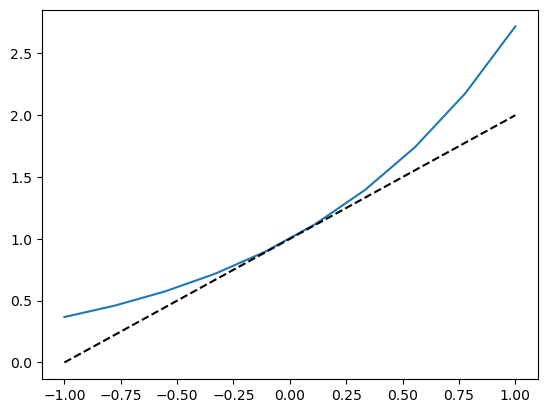

In [23]:
import matplotlib.pyplot as plt

t = np.linspace(-1, 1, 10)
plt.plot(t, np.exp(t))
t = np.linspace(-1, 1, 2)
plt.plot(t,t+1, ls='--', c='k');

You can see that the slope is very close to the curve at $t=0.1$, but far from it
at $t=1$. But let's continue with a step size of 1 for a moment. We can see that at $t=1$ the estimated value of $y$ is 2. Now we can compute the value at $t=2$ by taking the slope of the curve at $t=1$ and adding it to our initial estimate. The slope is computed with $y'=y$, so the slope is 2.

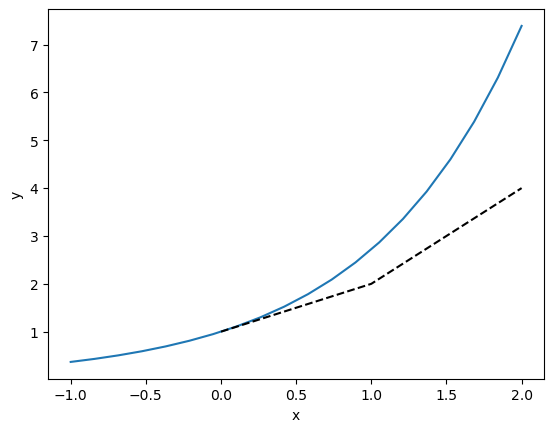

In [24]:
import kf_book.book_plots as book_plots

t = np.linspace(-1, 2, 20)
plt.plot(t, np.exp(t))
t = np.linspace(0, 1, 2)
plt.plot([1, 2, 4], ls='--', c='k')
book_plots.set_labels(x='x', y='y');

Here we see the next estimate for y is 4. The errors are getting large quickly, and you might be unimpressed. But 1 is a very large step size. Let's put this algorithm in code, and verify that it works by using a small step size.

In [25]:
def euler(t, tmax, y, dx, step=1.):
    ys = []
    while t < tmax:
        y = y + step*dx(t, y)
        ys.append(y)
        t +=step        
    return ys

In [26]:
def dx(t, y): return y

print(euler(0, 1, 1, dx, step=1.)[-1])
print(euler(0, 2, 1, dx, step=1.)[-1])

2.0
4.0


This looks correct. So now let's plot the result of a much smaller step size.

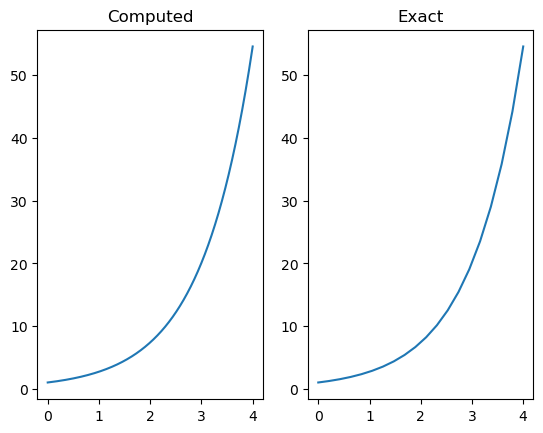

In [27]:
ys = euler(0, 4, 1, dx, step=0.00001)
plt.subplot(1,2,1)
plt.title('Computed')
plt.plot(np.linspace(0, 4, len(ys)),ys)
plt.subplot(1,2,2)
t = np.linspace(0, 4, 20)
plt.title('Exact')
plt.plot(t, np.exp(t));

In [28]:
print('exact answer=', np.exp(4))
print('euler answer=', ys[-1])
print('difference =', np.exp(4) - ys[-1])
print('iterations =', len(ys))

exact answer= 54.598150033144236
euler answer= 54.59705808834125
difference = 0.0010919448029866885
iterations = 400000


Here we see that the error is reasonably small, but it took a very large number of iterations to get three digits of precision. In practice Euler's method is too slow for most problems, and we use more sophisticated methods.

Before we go on, let's formally derive Euler's method, as it is the basis for the more advanced Runge Kutta methods used in the next section. In fact, Euler's method is the simplest form of Runge Kutta.


Here are the first 3 terms of the Taylor expansion of $y$. An infinite expansion would give an exact answer, so $O(h^4)$ denotes the error due to the finite expansion.

$$y(t_0 + h) = y(t_0) + h y'(t_0) + \frac{1}{2!}h^2 y''(t_0) + \frac{1}{3!}h^3 y'''(t_0) +  O(h^4)$$

Here we can see that Euler's method is using the first two terms of the Taylor expansion. Each subsequent term is smaller than the previous terms, so we are assured that the estimate will not be too far off from the correct value. 

### Runge Kutta Methods


Runge Kutta is the workhorse of numerical integration. There are a vast number of methods in the literature. In practice, using the Runge Kutta algorithm that I present here will solve most any problem you will face. It offers a very good balance of speed, precision, and stability, and it is the 'go to' numerical integration method unless you have a very good reason to choose something different.

Let's dive in. We start with some differential equation

$\ddot{y} = \frac{d}{dt}\dot{y}$.

We can substitute the derivative of y with a function f, like so

$\ddot{y} = \frac{d}{dt}f(y,t)$.

Deriving these equations is outside the scope of this book, but the Runge Kutta RK4 method is defined with these equations.

$$y(t+\Delta t) = y(t) + \frac{1}{6}(k_1 + 2k_2 + 2k_3 + k_4) + O(\Delta t^4)$$

$$\begin{aligned}
k_1 &= f(y,t)\Delta t \\
k_2 &= f(y+\frac{1}{2}k_1, t+\frac{1}{2}\Delta t)\Delta t \\
k_3 &= f(y+\frac{1}{2}k_2, t+\frac{1}{2}\Delta t)\Delta t \\
k_4 &= f(y+k_3, t+\Delta t)\Delta t
\end{aligned}
$$

Here is the corresponding code:

In [29]:
def runge_kutta4(y, x, dx, f):
    """computes 4th order Runge-Kutta for dy/dx.
    y is the initial value for y
    x is the initial value for x
    dx is the difference in x (e.g. the time step)
    f is a callable function (y, x) that you supply 
    to compute dy/dx for the specified values.
    """
    
    k1 = dx * f(y, x)
    k2 = dx * f(y + 0.5*k1, x + 0.5*dx)
    k3 = dx * f(y + 0.5*k2, x + 0.5*dx)
    k4 = dx * f(y + k3, x + dx)
    
    return y + (k1 + 2*k2 + 2*k3 + k4) / 6.

Let's use this for a simple example. Let

$$\dot{y} = t\sqrt{y(t)}$$

with the initial values

$$\begin{aligned}t_0 &= 0\\y_0 &= y(t_0) = 1\end{aligned}$$

max error 0.00005


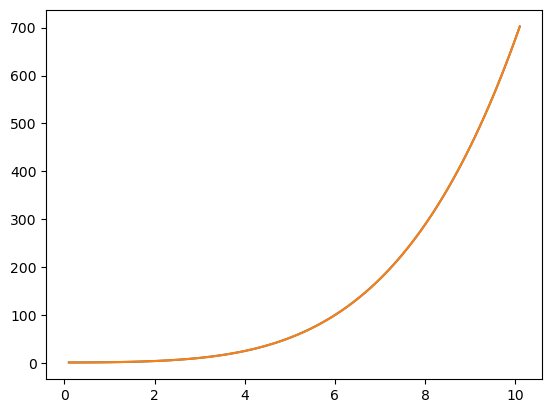

In [30]:
import math
import numpy as np
t = 0.
y = 1.
dt = .1

ys, ts = [], []

def func(y,t):
    return t*math.sqrt(y)

while t <= 10:
    y = runge_kutta4(y, t, dt, func)
    t += dt
    ys.append(y)
    ts.append(t)

exact = [(t**2 + 4)**2 / 16. for t in ts]
plt.plot(ts, ys)
plt.plot(ts, exact)

error = np.array(exact) - np.array(ys)
print(f"max error {max(error):.5f}")

## Bayesian Filtering

Starting in the Discrete Bayes chapter I used a Bayesian formulation for filtering. Suppose we are tracking an object. We define its *state* at a specific time as its position, velocity, and so on. For example, we might write the state at time $t$ as $\mathbf x_t = \begin{bmatrix}x_t &\dot x_t \end{bmatrix}^\mathsf T$. 

When we take a measurement of the object we are measuring the state or part of it. Sensors are noisy, so the measurement is corrupted with noise. Clearly though, the measurement is determined by the state. That is, a change in state may change the measurement, but a change in measurement will not change the state.

In filtering our goal is to compute an optimal estimate for a set of states $\mathbf x_{0:t}$ from time 0 to time $t$. If we knew $\mathbf x_{0:t}$ then it would be trivial to compute a set of measurements $\mathbf z_{0:t}$ corresponding to those states. However, we receive a set of measurements $\mathbf z_{0:t}$, and want to compute the corresponding states $\mathbf x_{0:t}$. This is called *statistical inversion* because we are trying to compute the input from the output. 

Inversion is a difficult problem because there is typically no unique solution. For a given set of states $\mathbf x_{0:t}$ there is only one possible set of measurements (plus noise), but for a given set of measurements there are many different sets of states that could have led to those measurements. 

Recall Bayes Theorem:

$$P(x \mid z) = \frac{P(z \mid x)P(x)}{P(z)}$$

where $P(z \mid x)$ is the *likelihood* of the measurement $z$, $P(x)$ is the *prior* based on our process model, and $P(z)$ is a normalization constant. $P(x \mid z)$ is the *posterior*, or the distribution after incorporating the measurement $z$, also called the *evidence*.

This is a *statistical inversion* as it goes from $P(z \mid x)$ to $P(x \mid z)$. The solution to our filtering problem can be expressed as:

$$P(\mathbf x_{0:t} \mid \mathbf z_{0:t}) = \frac{P(\mathbf z_{0:t} \mid \mathbf x_{0:t})P(\mathbf x_{0:t})}{P(\mathbf z_{0:t})}$$

That is all well and good until the next measurement $\mathbf z_{t+1}$ comes in, at which point we need to recompute the entire expression for the range $0:t+1$. 

In practice this is intractable because we are trying to compute the posterior distribution $P(\mathbf x_{0:t} \mid \mathbf z_{0:t})$ for the state over the full range of time steps. But do we really care about the probability distribution at the third step (say) when we just received the tenth measurement? Not usually. So we relax our requirements and only compute the distributions for the current time step. 

The first simplification is we describe our process (e.g., the motion model for a moving object) as a *Markov chain*. That is, we say that the current state is solely dependent on the previous state and a transition probability $P(\mathbf x_k \mid \mathbf x_{k-1})$, which is just the probability of going from the last state to the current one. We write:

$$\mathbf x_k \sim P(\mathbf x_k \mid \mathbf x_{k-1})$$

In practice this is extremely reasonable, as many things have the *Markov property*. If you are driving in a parking lot, does your position in the next second depend on whether you pulled off the interstate or were creeping along on a dirt road one minute ago? No. Your position in the next second depends solely on your current position, speed, and control inputs, not on what happened a minute ago. Thus, cars have the Markov property, and we can make this simplification with no loss of precision or generality.

The next simplification we make is do define the *measurement model* as depending on the current state $\mathbf x_k$ with the conditional probability of the measurement given the current state: $P(\mathbf z_k \mid \mathbf x_k)$. We write:

$$\mathbf z_k \sim P(\mathbf z_k \mid \mathbf x_k)$$

We have a recurrence now, so we need an initial condition to terminate it. Therefore we say that the initial distribution is the probablity of the state $\mathbf x_0$:

$$\mathbf x_0 \sim P(\mathbf x_0)$$


These terms are plugged into Bayes equation. If we have the state $\mathbf x_0$ and the first measurement we can estimate $P(\mathbf x_1 | \mathbf z_1)$. The motion model creates the prior $P(\mathbf x_2 \mid \mathbf x_1)$. We feed this back into Bayes theorem to compute $P(\mathbf x_2 | \mathbf z_2)$. We continue this predictor-corrector algorithm, recursively computing the state and distribution at time $t$ based solely on the state and distribution at time $t-1$ and the measurement at time $t$.

The details of the mathematics for this computation varies based on the problem. The **Discrete Bayes** and **Univariate Kalman Filter** chapters gave two different formulations which you should have been able to reason through. The univariate Kalman filter assumes that for a scalar state both the noise and process are linear model are affected by zero-mean, uncorrelated Gaussian noise. 

The Multivariate Kalman filter makes the same assumption but for states and measurements that are vectors, not scalars. Dr. Kalman was able to prove that if these assumptions hold true then the Kalman filter is *optimal* in a least squares sense. Colloquially this means there is no way to derive more information from the noisy measurements. In the remainder of the book I will present filters that relax the constraints on linearity and Gaussian noise.

Before I go on, a few more words about statistical inversion. As Calvetti and Somersalo write in *Introduction to Bayesian Scientific Computing*, "we adopt the Bayesian point of view: *randomness simply means lack of information*"[3]. Our state parameterizes physical phenomena that we could in principle measure or compute: velocity, air drag, and so on. We lack enough information to compute or measure their value, so we opt to consider them as random variables. Strictly speaking they are not random, thus this is a subjective position. 

They devote a full chapter to this topic. I can spare a paragraph. Bayesian filters are possible because we ascribe statistical properties to unknown parameters. In the case of the Kalman filter we have closed-form solutions to find an optimal estimate. Other filters, such as the discrete Bayes filter or the particle filter which we cover in a later chapter, model the probability in a more ad-hoc, non-optimal manner. The power of our technique comes from treating lack of information as a random variable, describing that random variable as a probability distribution, and then using Bayes Theorem to solve the statistical inference problem.

## Converting Kalman Filter to a g-h Filter

I've stated that the Kalman filter is a form of the g-h filter. It just takes some algebra to prove it. It's more straightforward to do with the one dimensional case, so I will do that. Recall 

$$
\mu_{x}=\frac{\sigma_1^2 \mu_2 + \sigma_2^2 \mu_1} {\sigma_1^2 + \sigma_2^2}
$$

which I will make more friendly for our eyes as:

$$
\mu_{x}=\frac{ya + xb} {a+b}
$$

We can easily put this into the g-h form with the following algebra

$$
\begin{aligned}
\mu_{x}&=(x-x) + \frac{ya + xb} {a+b} \\
\mu_{x}&=x-\frac{a+b}{a+b}x  + \frac{ya + xb} {a+b} \\ 
\mu_{x}&=x +\frac{-x(a+b) + xb+ya}{a+b} \\
\mu_{x}&=x+ \frac{-xa+ya}{a+b}  \\
\mu_{x}&=x+ \frac{a}{a+b}(y-x)\\
\end{aligned}
$$

We are almost done, but recall that the variance of estimate is given by 

$$\begin{aligned}
\sigma_{x}^2 &= \frac{1}{\frac{1}{\sigma_1^2} +  \frac{1}{\sigma_2^2}} \\
&= \frac{1}{\frac{1}{a} +  \frac{1}{b}}
\end{aligned}$$

We can incorporate that term into our equation above by observing that

$$ 
\begin{aligned}
\frac{a}{a+b} &= \frac{a/a}{(a+b)/a} = \frac{1}{(a+b)/a}  \\
 &= \frac{1}{1 + \frac{b}{a}} = \frac{1}{\frac{b}{b} + \frac{b}{a}}  \\
 &= \frac{1}{b}\frac{1}{\frac{1}{b} + \frac{1}{a}} \\
 &= \frac{\sigma^2_{x}}{b}
 \end{aligned}
$$

We can tie all of this together with

$$
\begin{aligned}
\mu_{x}&=x+ \frac{a}{a+b}(y-x) \\
&= x + \frac{\sigma^2_{x}}{b}(y-x) \\
&= x + g_n(y-x)
\end{aligned}
$$

where

$$g_n = \frac{\sigma^2_{x}}{\sigma^2_{y}}$$

The end result is multiplying the residual of the two measurements by a constant and adding to our previous value, which is the $g$ equation for the g-h filter. $g$ is the variance of the new estimate divided by the variance of the measurement. Of course in this case $g$ is not a constant as it varies with each time step as the variance changes. We can also derive the formula for $h$ in the same way. It is not a particularly illuminating derivation and I will skip it. The end result is

$$h_n = \frac{COV (x,\dot x)}{\sigma^2_{y}}$$

The takeaway point is that $g$ and $h$ are specified fully by the variance and covariances of the measurement and predictions at time $n$. In other words, we are picking a point between the measurement and prediction by a scale factor determined by the quality of each of those two inputs.

## References

 * [1] C.B. Molwer and C.F. Van Loan "Nineteen Dubious Ways to Compute the Exponential of a Matrix, Twenty-Five Years Later,", *SIAM Review 45, 3-49*. 2003.


 * [2] C.F. van Loan, "Computing Integrals Involving the Matrix Exponential," IEEE *Transactions Automatic Control*, June 1978.
 
 
 * [3] Calvetti, D and Somersalo E, "Introduction to Bayesian Scientific Computing: Ten Lectures on Subjective Computing,", *Springer*, 2007.
 
 * [4] Brown, R. G. and Hwang, P. Y.C., "Introduction to Random Signals and Applied Kalman Filtering", *Wiley and Sons*, Fourth Edition, p.143-147, 2012. 
 